In [22]:
import pandas as pd
import numpy as np
import pvlib
import datetime
from solar_forecaster.herbie_gefs_tools import get_tcc_fcasts_fastherbie, get_tcc_fcast
from solar_forecaster.herbie_hrrr_tools import get_hrrr_fcasts_fastherbie
import matplotlib.pyplot as plt
import xgboost as xgb
from quantile_forest import RandomForestQuantileRegressor
import joblib

Load plant specs:

In [2]:
plants_df = pd.read_csv('pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants

Calculate initialization time for GEFS:

In [45]:
# get delay_to_first_forecast and update_freq from 
# https://github.com/SolarArbiter/solarforecastarbiter-core/blob/master/solarforecastarbiter/io/fetch/nwp.py
delay_to_first_forecast = '280min'
update_freq = '6h'

time_now = pd.Timestamp(datetime.datetime.now().isoformat())
init_time = (time_now - pd.Timedelta(delay_to_first_forecast)).floor(update_freq)
print(init_time)

2024-04-15 12:00:00


Get GEFS data:

In [46]:
num_members = 3 # Number of ensemble members to pull, max of 30
freq='1D' # how often to pull a new forecast
fxx_interval = 3 # time step of the forecast, GEFS has 3 hour intervals
fxx_range = range(12,46,fxx_interval)

# lat, lon extent for region of interest
# (left lon, right lon, lower lat, upper lat)
region_extent = [-92, -80, 29, 36]

start = init_time
end = init_time

save_dir = 'nc_files/gefs/'
remove_grib=True
w_avg_tcc = get_tcc_fcasts_fastherbie(start, end, freq, fxx_range, plants_df,
                              region_extent=region_extent, num_members=num_members,
                              save=False, save_dir='', attempts=5, remove_grib=False)

# clean up indices and localize to UTC
w_avg_tcc = w_avg_tcc.reset_index().set_index('valid_time_utc_end_of_interval').tz_localize('UTC')
w_avg_tcc.head()

downloading new data
member 1 download complete
member 2 download complete
member 3 download complete
downloaded and processed 


,time_utc,step,tcc_std,tcc_p01,tcc_p02,tcc_p03
valid_time_utc_end_of_interval,,,,,,
2024-04-15 22:00:00+00:00,2024-04-15 12:00:00,0 days 12:00:00,4.888957,12.706321,5.495143,3.381912
2024-04-15 23:00:00+00:00,2024-04-15 12:00:00,0 days 12:00:00,4.888957,12.706321,5.495143,3.381912
2024-04-16 00:00:00+00:00,2024-04-15 12:00:00,0 days 12:00:00,4.888957,12.706321,5.495143,3.381912
2024-04-16 01:00:00+00:00,2024-04-15 12:00:00,0 days 15:00:00,1.401468,17.597207,16.642171,14.837527
2024-04-16 02:00:00+00:00,2024-04-15 12:00:00,0 days 15:00:00,1.401468,17.597207,16.642171,14.837527


Calculate initialization time for HRRR:

In [47]:
# get delay_to_first_forecast and update_freq from 
# https://github.com/SolarArbiter/solarforecastarbiter-core/blob/master/solarforecastarbiter/io/fetch/nwp.py
delay_to_first_forecast = '45min' 
update_freq = '6h' # HRRR updates hourly, but only goes out 48 hours at 00Z, 06Z, 12Z, and 18Z forecasts

time_now = pd.Timestamp(datetime.datetime.now().isoformat())
init_time = (time_now - pd.Timedelta(delay_to_first_forecast)).floor(update_freq)
print(init_time)

2024-04-15 18:00:00


Get HRRR data:

In [48]:
freq = '24h'
fxx_range = range(12,45)
query_len_days = 3

save_dir = 'nc_files/hrrr/'
remove_grib=True
region_extent=[220,440,1080,1440]

start = init_time
end = init_time

# coarsened mean
ds, p_ac_all_fcast, _, p_ac_all_cs, _ = get_hrrr_fcasts_fastherbie(start, end, freq, fxx_range, plants_df,
                              region_extent=region_extent, save=False, 
                              save_dir='', attempts=5, transposition_model='perez',
                              decomposition_model='erbs', coarsen_type='mean',
                              window_size=10)

# coarsened max
_, p_ac_all_fcast_max, _, _, _ = get_hrrr_fcasts_fastherbie(start, end, freq, fxx_range, plants_df,
                              region_extent=region_extent, save=False, 
                              save_dir='', attempts=5, transposition_model='perez',
                              decomposition_model='erbs', coarsen_type='max',
                              window_size=10)

# coarsened min
_, p_ac_all_fcast_min, _, _, _ = get_hrrr_fcasts_fastherbie(start, end, freq, fxx_range, plants_df,
                              region_extent=region_extent, save=False, 
                              save_dir='', attempts=5, transposition_model='perez',
                              decomposition_model='erbs', coarsen_type='min',
                              window_size=10)

downloading new data


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


variable group 1 download complete
variable group 2 download complete
variable group 3 download complete
downloaded and processed 


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "t2m_c".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "wspd".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "t2m".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "u10".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_he

downloading new data


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


variable group 1 download complete
variable group 2 download complete
variable group 3 download complete
downloaded and processed 


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "t2m_c".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "wspd".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "t2m".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "u10".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_he

downloading new data


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


variable group 1 download complete
variable group 2 download complete
variable group 3 download complete
downloaded and processed 


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "t2m_c".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "wspd".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "t2m".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "u10".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_he

Load models that we trained previously:

In [49]:
booster = xgb.Booster()
booster.load_model("regression_models/xgboost_model.json")
qrf = joblib.load('regression_models/qrf_file.joblib')


pi_list_xgb = [.9995, .999, .99, .96, .57] 
pi_list_rf = [.995, .99, .98, .95, .5]

In [50]:
p_ac_all_cs.rename(columns={'power_ac': 'p_ac_all_cs'}, inplace=True)
p_ac_all_fcast.rename(columns={'power_ac': 'p_ac_all_fcast'}, inplace=True)
p_ac_all_fcast_max.rename(columns={'power_ac': 'p_ac_all_fcast_max'}, inplace=True)
p_ac_all_fcast_min.rename(columns={'power_ac': 'p_ac_all_fcast_min'}, inplace=True)

# list of dataframes to combine first
dfs = [
    p_ac_all_fcast,
    p_ac_all_fcast_max,
    p_ac_all_fcast_min,
    p_ac_all_cs,
    w_avg_tcc.tcc_std,
    ]

# combine all dataframes and drop na rows
df = pd.concat(dfs, axis=1).dropna()

df.index.name = 'time_center_labeled'

# calculate normalized max-min
df['max_min_norm'] = (df['p_ac_all_fcast_max'] - df['p_ac_all_fcast_min'])/df['p_ac_all_cs']

# normalize forecast to clear sky
df['csi_fcast'] = df['p_ac_all_fcast']/df['p_ac_all_cs']

latitude, longitude = 32.8 , -83.6
solpos = pvlib.solarposition.get_solarposition(time=df.index,latitude=latitude, longitude=longitude)

df['hour'] = df.index.hour
df['month'] = df.index.month
df['el'] = solpos.apparent_elevation
df['zen'] = solpos.apparent_zenith
df['az'] = solpos.azimuth

In [51]:
filtered_df = df.dropna()
approx_nameplate = plants_df['ac_capacity'].sum() 
filtered_df = filtered_df[filtered_df['p_ac_all_cs'] >= approx_nameplate*.001]

X=filtered_df[['tcc_std']].copy()
X['max_min_norm'] = filtered_df['max_min_norm']
X['csi_fcast'] = filtered_df['csi_fcast']
X['zen'] = filtered_df['zen']
X['az'] = filtered_df['az']
X['month'] = filtered_df['month']

In [52]:
y_pred = booster.inplace_predict(X)

In [53]:
pi_list = pi_list_xgb
percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

# create a results dataframe
result_df = X.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

In [54]:
result_df_XGB = result_df.copy()

In [55]:
y_pred = qrf.predict(X, quantiles=percentile_list)

c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [56]:
pi_list = pi_list_rf
percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

# create a results dataframe
result_df = X.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

In [57]:
result_df_RF = result_df.copy()

In [58]:
# create new hyrbid dataframe, starting with RF because PIs were accurate so we can keep column names
result_df_hybrid = result_df_RF.copy()

# find columns that end in `_p_ac` (e.g., '0.015_p_ac')
rf_columns = result_df_RF.filter(regex='_p_ac$').columns
xgb_columns = result_df_XGB.filter(regex='_p_ac$').columns

# loop through, selecting max of lower bounds and min of upper bounds
for i in range(len(rf_columns)):
    if i == 0: # first
        print('extreme lower bound from rf', rf_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    elif i == len(rf_columns)-1: # last
        print('extreme upper bound from rf', rf_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    elif i < (len(rf_columns)-1)/2:
        print('lower bounds', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = np.maximum(result_df_XGB[xgb_columns[i]], result_df_RF[rf_columns[i]])
        # result_df_hybrid_2023[rf_columns[i]] = pd.DataFrame([result_df_XGB_2023[xgb_columns[i]], result_df_RF_2023[rf_columns[i]]]).max(axis=0)
    elif i == (len(rf_columns)-1)/2:
        print('mid', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    else:
        print('upper bounds', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = np.minimum(result_df_XGB[xgb_columns[i]], result_df_RF[rf_columns[i]])


extreme lower bound from rf 0.0025_p_ac
lower bounds 0.005_p_ac 0.0005_p_ac
lower bounds 0.01_p_ac 0.005_p_ac
lower bounds 0.025_p_ac 0.02_p_ac
lower bounds 0.25_p_ac 0.215_p_ac
mid 0.5_p_ac 0.5_p_ac
upper bounds 0.75_p_ac 0.785_p_ac
upper bounds 0.975_p_ac 0.98_p_ac
upper bounds 0.99_p_ac 0.995_p_ac
upper bounds 0.995_p_ac 0.9995_p_ac
extreme upper bound from rf 0.9975_p_ac


In [59]:
result_df = result_df_hybrid.copy()

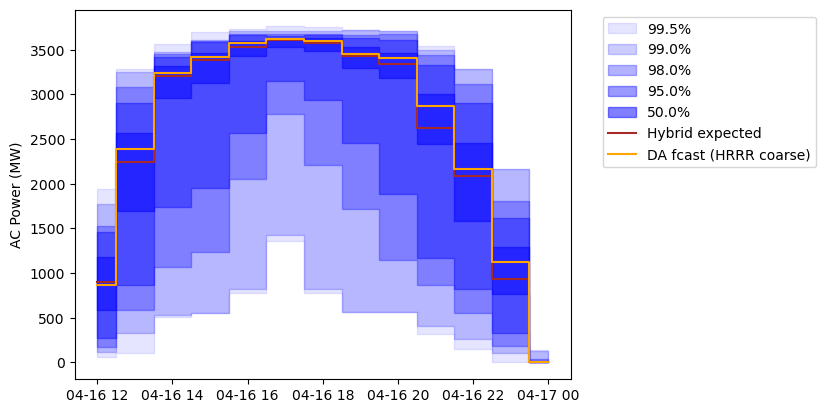

In [60]:
for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index,# x
                     result_df[str(percentile_list[i])+'_p_ac'].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index,
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'],
         label='Hybrid expected',color='brown', drawstyle='steps-mid')
# plt.plot(result_df.index,result_df['p_ac_all_act'],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index,result_df['p_ac_all_fcast'],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [61]:
result_df

,tcc_std,max_min_norm,csi_fcast,zen,az,month,p_ac_all_fcast,p_ac_all_fcast_max,p_ac_all_fcast_min,p_ac_all_cs,...,0.005_p_ac,0.01_p_ac,0.025_p_ac,0.25_p_ac,0.5_p_ac,0.75_p_ac,0.975_p_ac,0.99_p_ac,0.995_p_ac,0.9975_p_ac
time_center_labeled,,,,,,,,,,,,,,,,,,,,,
2024-04-16 12:00:00+00:00,15.490453,0.458726,0.443728,78.903983,84.645962,4,866.975819,1274.027838,377.747004,1953.846851,...,117.200769,171.188559,271.396338,588.356306,898.304944,1182.776518,1462.181718,1525.541232,1771.639381,1939.593363
2024-04-16 13:00:00+00:00,2.319841,0.399630,0.723088,66.343621,92.701321,4,2393.926775,2991.493288,1668.438315,3310.697689,...,332.887062,587.006898,866.829228,1692.569251,2243.191258,2570.213848,2906.024621,3086.717281,3251.584233,3289.824991
2024-04-16 14:00:00+00:00,2.319841,0.226412,0.926135,53.849742,101.761572,4,3241.550606,3427.698285,2635.236387,3500.082457,...,535.063984,1073.663018,1743.576788,2960.878851,3201.763789,3315.255573,3419.946058,3456.639184,3476.314664,3564.785409
2024-04-16 15:00:00+00:00,2.319841,0.174018,0.941211,41.826264,113.360148,4,3416.895678,3571.702286,2939.960183,3630.316667,...,554.973125,1238.772217,1950.536870,3128.082011,3381.276989,3463.602953,3590.733807,3596.857683,3607.724474,3697.427145
2024-04-16 16:00:00+00:00,1.959429,0.105404,0.968088,31.086060,130.573877,4,3572.904174,3663.847349,3274.834446,3690.682961,...,818.536779,2055.124529,2563.305473,3427.438044,3535.531902,3602.497958,3667.017094,3678.988066,3706.034614,3728.638058
2024-04-16 17:00:00+00:00,1.959429,0.057000,0.981329,23.655315,158.747077,4,3623.236377,3667.392584,3456.937908,3692.171401,...,1426.511404,2775.935994,3146.873266,3536.554542,3608.864603,3614.479009,3659.179082,3675.867473,3708.872556,3761.029376
2024-04-16 18:00:00+00:00,1.959429,0.085937,0.975359,23.094079,196.468064,4,3600.252822,3664.249309,3347.038684,3691.206134,...,820.111056,2213.193578,2939.720939,3490.598104,3571.747297,3630.689569,3665.347562,3675.818862,3706.506720,3759.442221
2024-04-16 19:00:00+00:00,3.381094,0.143874,0.934874,29.795953,226.462330,4,3450.998746,3615.996480,3084.897367,3691.406926,...,564.312104,1722.601677,2457.146553,3298.655263,3430.296567,3527.176996,3637.359985,3668.723449,3720.678464,3720.678464
2024-04-16 20:00:00+00:00,3.381094,0.227302,0.927374,40.238388,244.837673,4,3409.267688,3625.943483,2790.320474,3676.261028,...,561.996723,1142.787303,1886.840291,3189.317303,3338.261488,3460.145809,3612.349646,3671.538846,3705.412464,3706.282327
